# Surface Mass Balance: Clustering of Stations 

Import relevant Libaries 

In [1]:
%pip install pyarrow
%pip install plotly
%pip install feature_engine
%pip update pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "update"
Note: you may need to restart the kernel to use updated packages.


In [47]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Visualizations
import matplotlib.pyplot as plt
from matplotlib import pyplot

# TS
from statsmodels.tsa.seasonal import seasonal_decompose

# Set WD
import os
from pyrsistent import v
os.getcwd()
#os.chdir('/Users/asgerlyngeholst-hansen/Desktop/GEUS-Master-Thesis/')
#os.chdir('C:\\Users\\nifu18ab\\Desktop\\GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/GEUS-Master-Thesis')
os.chdir('/Users/nilsfulde/Desktop/Master_Thesis')

## Load Stations

In [62]:
# Load Unique Stations
station_list = pd.read_csv('data/promice/stations.csv')

# This bit to define the data that is to be loaded
import glob

# Define the directory path where the CSV files are located
input_path = 'data/promice/preprocessed/Analysis/'

# Define a pattern to match the filenames of the CSV files
pattern = '*.csv'
#staion_list = ['SCO_L.csv','KAN_L.csv']

# Use glob to get a list of all files that match the pattern
filenames = glob.glob(input_path + pattern)

dfs = []
for file in filenames:
    df = pd.read_csv(file, index_col=False)
    dfs.append(df)
df = pd.concat(dfs)

df = df.reset_index(drop=True)

df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")

## Time Series Decomposition

In [63]:
# https://datastud.dev/posts/python-seasonality-how-to

In [64]:
# This bit to decompose for each station
for i in df["stid"].unique().tolist():
    df_station = df[df['stid'] == i]
    if len(df_station) > 730: 
        exec(f"result_{i} = seasonal_decompose(df_station['Surface height from combined measurements'], model='additive', period=365)")
    else:
        print("Station to remove:", i, "(", len(df_station), ")")
    

Station to remove: ZAK_Uv3 ( 249 )


In [65]:
df = df[df['stid'] != "ZAK_Uv3"]

In [66]:
# This bit to add decomposition to df and smooth the residual component
ts = pd.DataFrame()

for i in df["stid"].unique().tolist():
    
    # Get data frame for the current station
    df_station = df[df['stid'] == i]

    df_station['observed'] = eval(f"result_{i}.observed")
    df_station['residual'] = eval(f"result_{i}.resid") 
    df_station['seasonal'] = eval(f"result_{i}.seasonal") 
    df_station['trend'] = eval(f"result_{i}.trend")
    df_station['residual_smoothed'] = eval(f"result_{i}.resid") 
    
    # Set the window size and threshold
    window_size = 7
    
    #Outliers based on incremental sum
    threshold_incremental_sum = df_station['residual'].diff().rolling(window_size).sum().quantile(0.8)
    threshold_slope = df_station['residual_smoothed'].diff().abs().quantile(0.8)
        # Calculate the sum of incremental changes over the rolling window
    incremental_sum = df_station['residual'].diff().rolling(window_size).sum()
        # Replace the residuals that exceed the threshold with NaN
    df_station['residual_smoothed'] = df_station['residual']
    df_station.loc[incremental_sum > threshold_incremental_sum, 'residual_smoothed'] = np.nan

    # Outliers based on slope
    slope = df_station['residual_smoothed'].diff().abs()
        # Calculate the 80th percentile of the slopes
    threshold_slope = slope.quantile(0.8)
        # Remove values where the slope is steeper than the threshold
    df_station.loc[slope > threshold_slope, 'residual_smoothed'] = np.nan

    # fill in the NaN values with linear interpolation
    df_station['residual_smoothed'].interpolate(method='linear', inplace=True)

    # Add new column for seasonal residual
    df_station['seasonal_residual'] = df_station['residual_smoothed'].fillna(0) + df_station['seasonal']
    
    # Add column for current station
    df_station['stid'] = i
    
    # Append to time series data frame
    ts = ts.append(df_station[['Datetime', 'stid', 'observed', 'residual', 'seasonal', 'trend', 'residual_smoothed', 'seasonal_residual']])

# Merge time series data frame with original data frame
df = pd.merge(df, ts, on=['Datetime', 'stid'], how='left')


In [67]:
# This bit to generate the periods that we want to focus on
df['seasonal'] = df['seasonal'].astype(float)
# create a new column to store the periods
df['Periods'] = ''

for i in df["stid"].unique().tolist():
    df_station = df[df['stid'] == i]
    # iterate over each year in the dataframe
    for year in df_station['Datetime'].dt.year.unique():
        year_data = df_station[df_station['Datetime'].dt.year == year]
        if len(year_data.index) > 300:
            max_index = year_data['seasonal'].idxmax()
            min_index = year_data['seasonal'].idxmin()

            # set the periods in the new column for the maximum value
            df.loc[max_index-5:max_index, 'Periods'] = 'pre_max'
            df.loc[max_index:max_index+6, 'Periods'] = 'post_max'

            # set the periods in the new column for the minimum value
            df.loc[min_index-5:min_index, 'Periods'] = 'pre_min'
            df.loc[min_index:min_index+6, 'Periods'] = 'post_min'
        else:
            continue 

In [68]:
def mround(x, m=5):
    '''Helper method for multiple round'''
    return int(m * round(float(x)/m))

def plot_components(df, station):
    """Plot data for initial visualization
    Args:
        df (pandas dataframe)
    """
    df = df[df['stid'] == station]
    
    df_axis = df.fillna(0)
    ymin = mround(np.min([df_axis.observed, df_axis.trend, df_axis.seasonal, df_axis.residual ]),5)
    ymax = mround(np.max([df_axis.observed, df_axis.trend, df_axis.seasonal, df_axis.residual]),5)
    ymin -= 5
    ymax += 5

    plt.figure(figsize=(20,20))

    #plt.subplot(4,1,1)
    #plt.title("Original Data")
    #plt.ylim(ymin, ymax)
    #plt.plot(df.index, df.observed)

    plt.subplot(4,1,1)
    plt.title("Trend")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.trend)

    plt.subplot(4,1,2)
    plt.title("Seasonal")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.seasonal)

    plt.subplot(4,1,3)
    plt.title("Residual")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.residual)
    
    plt.subplot(4,1,4)
    plt.title("residual_smoothed")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.residual_smoothed)

    
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    

In [69]:
df["stid"].unique().tolist()

['UPE_U',
 'MIT',
 'THU_L',
 'SCO_L',
 'QAS_L',
 'NUK_L',
 'NUK_U',
 'QAS_U',
 'TAS_L',
 'SCO_U',
 'KPC_L',
 'ZAK_U',
 'KAN_L',
 'UPE_L']

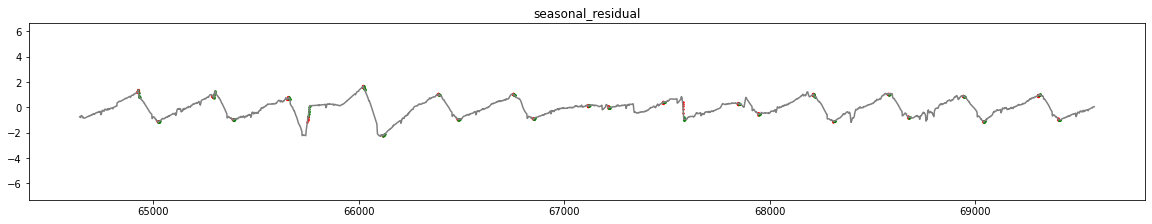

In [70]:
def plt_seasonal_residual(df,station):
    df = df[df['stid'] == station]
    
    df_axis = df.fillna(0)
    ymin = np.round(np.min([df_axis.seasonal_residual]), 5) - 5
    ymax = np.round(np.max([df_axis.seasonal_residual]), 5) + 5

    plt.figure(figsize=(20,15))

    # Plot the seasonal_residual values
    plt.subplot(4,1,4)
    plt.title("seasonal_residual")
    plt.ylim(ymin, ymax)

    # Plot the pre_max values
    pre_max_indices = df[df['Periods'] == 'pre_max'].index
    plt.scatter(pre_max_indices, df.loc[pre_max_indices, 'seasonal_residual'], c='r', marker='.', label='pre_max', s=20 )

    # Plot the post_max values
    post_max_indices = df[df['Periods'] == 'post_max'].index
    plt.scatter(post_max_indices, df.loc[post_max_indices, 'seasonal_residual'], c='g', marker='.', label='post_max',s=8)

    # Plot the pre_min values
    pre_min_indices = df[df['Periods'] == 'pre_min'].index
    plt.scatter(pre_min_indices, df.loc[pre_min_indices, 'seasonal_residual'], c='r', marker='.', label='pre_min',s=8)

    # Plot the post_min values
    post_min_indices = df[df['Periods'] == 'post_min'].index
    plt.scatter(post_min_indices, df.loc[post_min_indices, 'seasonal_residual'], c='g', marker='.', label='post_min',s=8)

    plt.plot(df.index, df.seasonal_residual, c = "grey")

plt_seasonal_residual(df,"UPE_L")


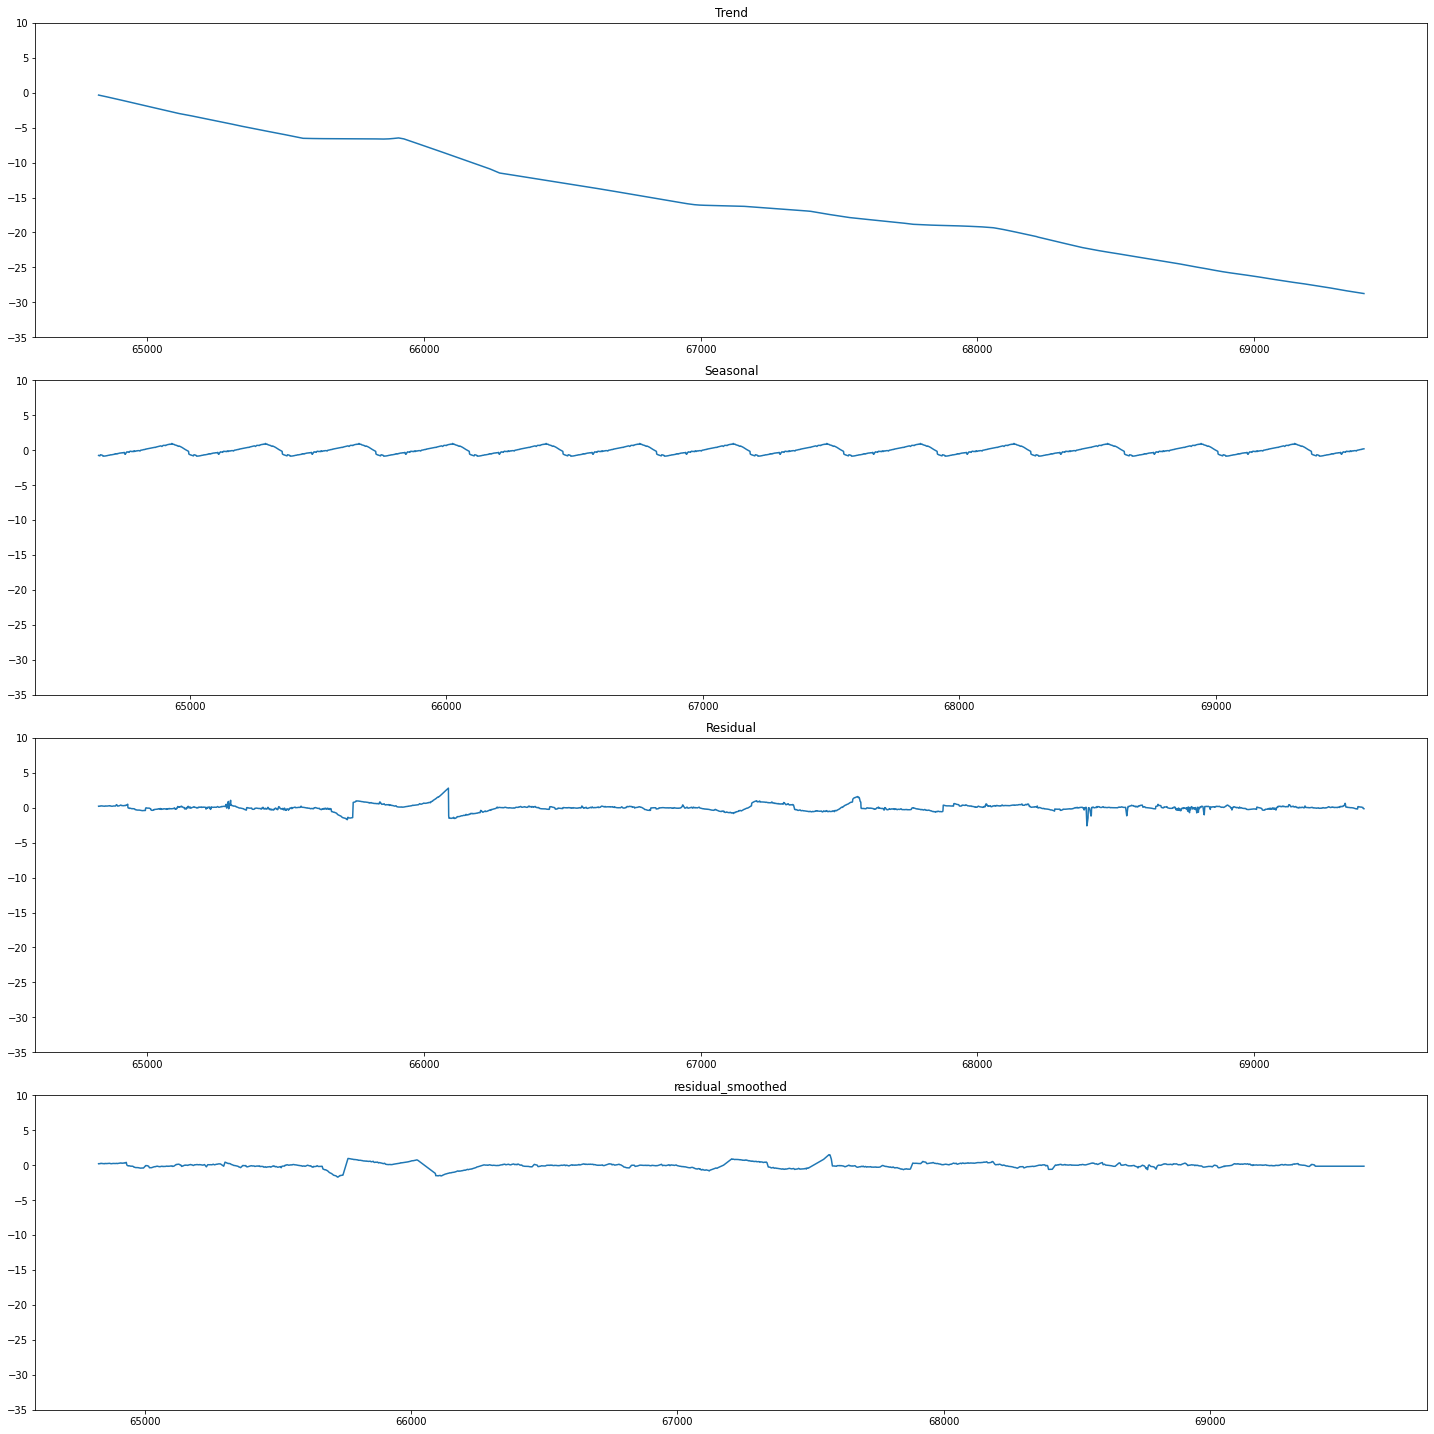

In [71]:
plot_components(df, 'UPE_L')

## Clustering Analysis

##### Set target variable and filter out needed columns

In [72]:
#y = 'seasonal_residual'
y = 'seasonal_residual'

In [73]:
df = df[['stid','Datetime', y]]
df = df[df[y].notna()] 

In [84]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Pivot the data to wide format
df_pivot = df.pivot(index='stid', columns='Datetime', values='seasonal_residual')

# Fill missing values with zeros
#df_pivot.fillna(0, inplace=True)
df_pivot = df_pivot.notna()

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(df_pivot)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Apply clustering algorithms
kmeans = KMeans(n_clusters=4, random_state=42)
agglomerative = AgglomerativeClustering(n_clusters=4)
dbscan = DBSCAN( min_samples=100)

# Fit the models
kmeans.fit(X_pca)
agglomerative.fit(X_pca)
dbscan.fit(X_pca)

# Print the results
print('KMeans labels:', kmeans.labels_)
print('Agglomerative labels:', agglomerative.labels_)
print('DBSCAN labels:', dbscan.labels_)
print('Silhouette score for KMeans:', silhouette_score(X_pca, kmeans.labels_))
print('Silhouette score for Agglomerative:', silhouette_score(X_pca, agglomerative.labels_))
print('Number of clusters in DBSCAN:', len(np.unique(dbscan.labels_)))

KMeans labels: [0 0 3 2 2 2 0 0 0 2 3 3 3 1]
Agglomerative labels: [1 1 0 2 2 2 1 1 1 2 0 0 0 3]
DBSCAN labels: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Silhouette score for KMeans: 0.7425265504357708
Silhouette score for Agglomerative: 0.7425265504357708
Number of clusters in DBSCAN: 1


--------